In [25]:
from graphMatching import *
from networkx import read_edgelist
from scipy.io import loadmat
from model_PyG import *
# from utils import *

In [26]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
from torch_geometric.utils import dense_to_sparse, negative_sampling
from torch_geometric.data import InMemoryDataset, Data
from torch.nn.functional import binary_cross_entropy_with_logits
from torch_geometric.transforms import (
	Compose,
	NormalizeFeatures,
	ToUndirected,
	AddSelfLoops,
	RemoveSelfLoops
)

In [27]:
import torch_geometric
print(torch_geometric.__version__)

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

2.7.0


In [28]:
def info(data):
	print("Validate:\t {}".format(data.validate(raise_on_error=True)))
	print("Num. nodes:\t {}".format(data.num_nodes))
	print("Num. edges:\t {}".format(data.num_edges))
	print("Num. features:\t {}".format(data.num_node_features))
	print("Has isolated:\t {}".format(data.has_isolated_nodes()))
	print("Has loops:\t {}".format(data.has_self_loops()))
	print("Is directed:\t {}".format(data.is_directed()))
	print("Is undirected:\t {}".format(data.is_undirected()))
	print("{}".format(data.edge_index))
	print("{}".format(data.x))
	print("{}".format(data.edge_weight))

### Setup

In [29]:
dataset = "Douban Online_Offline" # "Douban Online_Offline" # "ACM_DBLP" # args.dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if (dataset == "ACM_DBLP"):
	train_set = ["ACM", "DBLP"]
	b = np.load('data/ACM-DBLP.npz')
	# train_features["ACM"] = [torch.from_numpy(b["x1"]).float()]
	# train_features["DBLP"] = [torch.from_numpy(b["x2"]).float()]
	test_pairs = b['test_pairs'].astype(np.int32)
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	# input_dim = 17
	output_feature_size = 128
	lr = 5e-4 # 1e-4
	epoch = 100
elif (dataset == "Douban Online_Offline"):
	train_set = ["Online", "Offline"]
	a1, f1, a2, f2, test_pairs = load_douban()
	# f1 = f1.A
	# f2 = f2.A
	test_pairs = torch.tensor(np.array(test_pairs, dtype=int)) - 1
	test_pairs = test_pairs.numpy()
	# train_features["Online"] = [torch.from_numpy(f1).float()]
	# train_features["Offline"] = [torch.from_numpy(f2).float()]
	NUM_HIDDEN_LAYERS = 6
	HIDDEN_DIM = [512,512,512,512,512,512,512]
	# input_dim = 538
	output_feature_size = 512
	lr = 0.0001
	epoch = 100

### Understand Data (PyG)

#### Data (PyG)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 2]], dtype=torch.long)
x = torch.tensor([[-1, 4], [0, 1], [1, 2]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 1.0], dtype=torch.float)

data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 2]], dtype=torch.long)
x = torch.tensor([[-1, 4], [0, 1], [1, 2]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 1.0], dtype=torch.float)

data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

transform = Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device),
])

data = transform(data)

info(data)

#### Data ACM_DBLP

In [ ]:
train_set

In [ ]:
b.files

In [ ]:
edge_index1 = b["edge_index1"]
print(edge_index1.shape)
edge_index1

In [ ]:
edge_index2 = b["edge_index2"]
print(edge_index2.shape)
edge_index2

In [ ]:
x1 = b["x1"]
print(x1.shape)
x1

In [ ]:
x2 = b["x2"]
print(x2.shape)
x2

In [ ]:
test_pairs

#### Data Douban Online_Offline

In [ ]:
train_set

In [ ]:
a1, f1, a2, f2, test_pairs = load_douban()

In [ ]:
torch.from_numpy(a1.toarray())

In [ ]:
torch.from_numpy(a2.toarray())

In [ ]:
torch.from_numpy(f1.toarray())

In [ ]:
torch.from_numpy(f2.toarray())

In [ ]:
edge_index1, edge_attr1 = dense_to_sparse(torch.from_numpy(a1.toarray()))
print(edge_index1.shape)
edge_index1

In [ ]:
edge_index2, edge_attr2 = dense_to_sparse(torch.from_numpy(a2.toarray()))
print(edge_index2.shape)
edge_index2

In [ ]:
x1 = torch.from_numpy(f1.toarray()).float()
print(x1.shape)
x1

In [ ]:
x2 = torch.from_numpy(f2.toarray()).float()
print(x2.shape)
x2

In [ ]:
test_pairs

### Create Data (PyG)

In [31]:
transform = Compose([
	T.NormalizeFeatures(),
	# T.ToUndirected(),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device),
])

In [32]:
train_set

['Online', 'Offline']

In [33]:
print("Loading training datasets")
train_loader = {}

if dataset == "ACM_DBLP":
	for i, ts in enumerate(train_set):
		edge_index = torch.tensor(b[f"edge_index{i+1}"], dtype=torch.long)
		x = torch.tensor(b[f"x{i+1}"], dtype=torch.float)
		data = Data(x=x, edge_index=edge_index)
		data = transform(data)
		info(data)
		train_loader[ts] = data
elif dataset == "Douban Online_Offline":
	edge_index1, _= dense_to_sparse(torch.from_numpy(a1.toarray()))
	x1 = torch.from_numpy(f1.toarray()).float()
	data1 = Data(x=x1, edge_index=edge_index1)
	data1 = transform(data1)
	info(data1)
	train_loader[train_set[0]] = data1

	edge_index2, _= dense_to_sparse(torch.from_numpy(a2.toarray()))
	x2 = torch.from_numpy(f2.toarray()).float()
	data2 = Data(x=x2, edge_index=edge_index2)
	data2 = transform(data2)
	info(data2)
	train_loader[train_set[1]] = data2

Loading training datasets
Validate:	 True
Num. nodes:	 3906
Num. edges:	 15408
Num. features:	 538
Has isolated:	 False
Has loops:	 True
Is directed:	 True
Is undirected:	 False
tensor([[   0,    0,    1,  ..., 3903, 3904, 3905],
        [ 728, 3714,  160,  ..., 3903, 3904, 3905]], device='cuda:0')
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
None
Validate:	 True
Num. nodes:	 1118
Num. edges:	 4140
Num. features:	 538
Has isolated:	 False
Has loops:	 True
Is directed:	 False
Is undirected:	 True
tensor([[   0,    1,    1,  ..., 1115, 1116, 1117],
        [ 819,  268,  592,  ..., 1115, 1116, 1117]], device='cuda:0')
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0

In [34]:
train_loader

{'Online': Data(x=[3906, 538], edge_index=[2, 15408]),
 'Offline': Data(x=[1118, 538], edge_index=[2, 4140])}

### Train

In [35]:
def compute_num_neg_samples(edge_index, num_nodes, ratio):
	E = edge_index.size(1)
	max_neg = num_nodes * num_nodes - E
	return min(int(ratio * E), max_neg)

def neg_ratio_schedule(epoch, max_epoch):
	start = 5.0
	end = 1.0
	return start - (start - end) * (epoch / max_epoch)

class EarlyStopping:
	def __init__(self, patience=5, delta=0, warmup=5, verbose=False):
		self.patience = patience
		self.delta = delta
		self.warmup = warmup
		self.verbose = verbose
		self.best_loss = None
		self.no_improvement_count = 0
		self.stop_training = False
	
	def check_early_stop(self, loss, epoch):
		if epoch >= self.warmup:
			if self.best_loss is None or loss < self.best_loss - self.delta:
				self.best_loss = loss
				self.no_improvement_count = 0
			else:
				self.no_improvement_count += 1
				if self.no_improvement_count >= self.patience:
					self.stop_training = True
					if self.verbose:
						print("Stopping early as no improvement has been observed.")

In [36]:
def fit_TGAE_subgraph(dataset, no_samples, model, epochs, train_loader, train_features, device, lr, test_pairs):
	best_hitAtOne = 0
	best_hitAtFive = 0
	best_hitAtTen = 0
	best_hitAtFifty = 0
	list_loss = []

	optimizer = Adam(model.parameters(), lr=lr,weight_decay=5e-4)
	
	# Initialize early stopping
	patience = 10
	delta = 1e-4
	warmup = 10
	early_stopping = EarlyStopping(patience=patience, delta=delta, warmup=warmup, verbose=True)

	loop_obj = tqdm(range(1, epochs + 1))
	for epoch in loop_obj:
		loop_obj.set_description(f"Epoch: {epoch}")
		
		# Train
		model.train()
		loss = 0.0
		
		for _, data_obj in train_loader.items():
			x = data_obj.x
			edge_index = data_obj.edge_index
			
			# Encoder
			z = model(x, edge_index)
			# z = F.normalize(z, dim=1)

			# Positive edges
			pos_edge_index = edge_index
			
			# Negative edges
			# option 1
			neg_edge_index = negative_sampling(
				edge_index=edge_index,
				num_nodes=z.size(0),
				num_neg_samples=pos_edge_index.size(1), # Change 2 to other value if needed
				method="sparse"
			)
			# Negative edges (dynamic)
			# option 2
			""" ratio = neg_ratio_schedule(epoch, epochs)
			num_neg = compute_num_neg_samples(
				edge_index=edge_index,
				num_nodes=z.size(0),
				ratio=ratio
			)
			neg_edge_index = negative_sampling(
				edge_index=edge_index,
				num_nodes=z.size(0),
				num_neg_samples=num_neg,
				method="sparse"
			) """
			
			# Decoder
			pos_logits = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
			neg_logits = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)

			pos_labels = torch.ones_like(pos_logits)
			neg_labels = torch.zeros_like(neg_logits)

			# Loss
			loss_pos = binary_cross_entropy_with_logits(pos_logits, pos_labels)
			loss_neg = binary_cross_entropy_with_logits(neg_logits, neg_labels)

			loss += loss_pos + loss_neg
			
		optimizer.zero_grad()
		loss = loss / no_samples
		loss.backward()
		optimizer.step()

		loop_obj.set_postfix_str(f"Loss: {loss.item():.4f}")
		list_loss.append(loss.item())

		# Evaluation
		model.eval()
		with torch.no_grad():
			keys = list(train_loader.keys())
			data1 = train_loader[keys[0]]
			data2 = train_loader[keys[1]]

			z1 = model(data1.x, data1.edge_index).detach()
			z2 = model(data2.x, data2.edge_index).detach()

			# z1 = F.normalize(z1, dim=1)
			# z2 = F.normalize(z2, dim=1)
			
			D = torch.cdist(z1, z2, 2)
			
			if dataset == "ACM_DBLP":
				test_idx = test_pairs[:, 0].astype(int)
				labels = test_pairs[:, 1].astype(int)
			else:
				test_idx = test_pairs[0, :].astype(int)
				labels = test_pairs[1, :].astype(int)
				
			hitAtOne = 0
			hitAtFive = 0
			hitAtTen = 0
			hitAtFifty = 0
			hitAtHundred = 0
			for i in range(len(test_idx)):
				dist_list = D[test_idx[i]]
				sorted_neighbors = torch.argsort(dist_list).cpu()
				label = labels[i]
				for j in range(100):
					if (sorted_neighbors[j].item() == label):
						if (j == 0):
							hitAtOne += 1
							hitAtFive += 1
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 4):
							hitAtFive += 1
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 9):
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 49):
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 100):
							hitAtHundred += 1
							break
			cur_hitAtOne = hitAtOne / len(test_idx)
			cur_hitAtFive = hitAtFive / len(test_idx)
			cur_hitAtTen = hitAtTen / len(test_idx)
			cur_hitAtFifty = hitAtFifty / len(test_idx)

			if(cur_hitAtOne > best_hitAtOne): best_hitAtOne = cur_hitAtOne
			if (cur_hitAtFive > best_hitAtFive): best_hitAtFive = cur_hitAtFive
			if (cur_hitAtTen > best_hitAtTen): best_hitAtTen = cur_hitAtTen
			if (cur_hitAtFifty > best_hitAtFifty): best_hitAtFifty = cur_hitAtFifty

		# Check early stopping condition
		early_stopping.check_early_stop(loss.item(), epoch)
		if early_stopping.stop_training:
			print(f"Early stopping at epoch {epoch}")
			break

	print("The best results achieved:")
	print("Hit@1: ", end="")
	print(best_hitAtOne)
	print("Hit@5: ", end="")
	print(best_hitAtFive)
	print("Hit@10: ", end="")
	print(best_hitAtTen)
	print("Hit@50: ", end="")
	print(best_hitAtFifty)

	torch.cuda.empty_cache()

	return [z1, z2], list_loss

In [37]:
no_samples = len(train_set) # * (1 + 1)  # num datasets * num of samples by dataset 
input_dim = train_loader[train_set[0]].num_node_features

model = TGAE(NUM_HIDDEN_LAYERS,
			input_dim,
			HIDDEN_DIM,
			output_feature_size).to(device)

print("Generating training features")
print("Fitting model")
print(dataset, lr, epoch, input_dim, output_feature_size, no_samples)

list_z, list_loss = fit_TGAE_subgraph(dataset, no_samples, model, epoch, train_loader, None, device, lr,test_pairs)

Generating training features
Fitting model
Douban Online_Offline 0.0001 100 538 512 2


Epoch: 95:  94%|█████████▍| 94/100 [00:16<00:01,  5.73it/s, Loss: 0.8345]

Stopping early as no improvement has been observed.
Early stopping at epoch 95
The best results achieved:
Hit@1: 0.389087656529517
Hit@5: 0.59391771019678
Hit@10: 0.6753130590339893
Hit@50: 0.8568872987477638


### Plot

In [38]:
# Concatenate embeddings
z_cat = torch.cat(list_z, dim=0).cpu().numpy()
print(z_cat.shape)
z_cat

(5024, 512)


array([[-0.08577675, -0.0061276 , -0.1257727 , ...,  0.12648776,
         0.04936031, -0.13782653],
       [-0.11340492,  0.00332847, -0.09182446, ...,  0.07233219,
        -0.01429319, -0.01758027],
       [ 0.04390212, -0.04732919, -0.06084574, ...,  0.0007034 ,
         0.10023239, -0.10065065],
       ...,
       [ 0.00554216,  0.01158471, -0.0363552 , ...,  0.08381114,
        -0.0202806 , -0.14839438],
       [ 0.02389468, -0.02785201, -0.06012838, ..., -0.03612067,
        -0.00436384,  0.07327008],
       [ 0.04875262,  0.05358733,  0.08763497, ...,  0.03382288,
        -0.18895082, -0.10364196]], dtype=float32)

In [39]:
labels = np.array([
	i
	for i, z in enumerate(list_z)
	for _ in range(z.size(0))
])
print(labels.shape)
labels

(5024,)


array([0, 0, 0, ..., 1, 1, 1])

In [40]:
list_loss

[3.5378966331481934,
 2.2392523288726807,
 1.6189101934432983,
 1.4247794151306152,
 1.366800308227539,
 1.3071789741516113,
 1.2687876224517822,
 1.2320290803909302,
 1.1884369850158691,
 1.156789779663086,
 1.1287920475006104,
 1.1028432846069336,
 1.0951576232910156,
 1.0868785381317139,
 1.0686187744140625,
 1.0424144268035889,
 1.0463685989379883,
 1.0258679389953613,
 1.0116500854492188,
 1.0041873455047607,
 0.98183274269104,
 0.9841660261154175,
 0.9750092029571533,
 0.9686711430549622,
 0.9653011560440063,
 0.947142481803894,
 0.9520329236984253,
 0.9445253610610962,
 0.9464859366416931,
 0.9249629378318787,
 0.9247500896453857,
 0.9180065393447876,
 0.9179157018661499,
 0.9163846969604492,
 0.9064745903015137,
 0.9178357124328613,
 0.8989248871803284,
 0.8917834758758545,
 0.8934069871902466,
 0.8822492361068726,
 0.8796800374984741,
 0.8838081359863281,
 0.885161280632019,
 0.8920361995697021,
 0.8812605142593384,
 0.8714216351509094,
 0.869350790977478,
 0.8674700260162354,

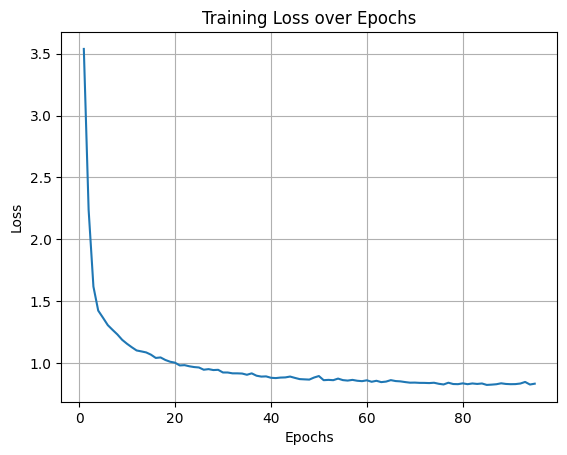

In [41]:
# Loss

plt.figure()
plt.plot(range(1, len(list_loss) + 1), list_loss) #, marker=".")
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

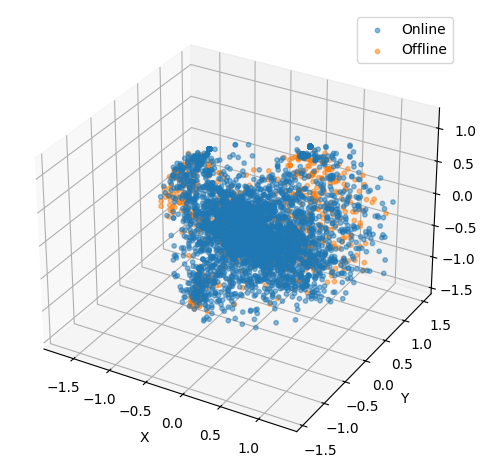

In [42]:
# Node embeddings 3D

if z_cat.shape[1] > 3:
	pca = PCA(n_components=3)
	z_cat_3d = pca.fit_transform(z_cat)
else:
	z_cat_3d = z_cat.copy()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

for c in np.unique(labels):
	ax.scatter(
		z_cat_3d[:, 0][labels == c],
		z_cat_3d[:, 1][labels == c], 
		z_cat_3d[:, 2][labels == c],
		s=10,
		alpha=0.5,
		label=f"{train_set[c]}"
	)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.tight_layout()
plt.show()

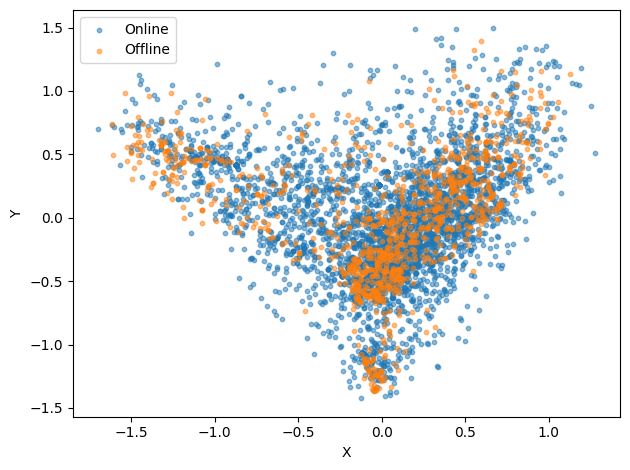

In [43]:
# Node embeddings 2D

if z_cat.shape[1] > 2:
	pca = PCA(n_components=2)
	z_cat_2d = pca.fit_transform(z_cat)
else:
	z_cat_2d = z_cat.copy()

fig, ax = plt.subplots()

for c in np.unique(labels):
	idx = labels == c
	ax.scatter(
		z_cat_2d[idx, 0],
		z_cat_2d[idx, 1],
		s=10,
		alpha=0.5,
		label=f"{train_set[c]}"
	)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()
plt.tight_layout()
plt.show()